In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import time
import os
import sys
sys.path.append("../..")

import scipy
from scipy.stats import sem
from scipy.io import loadmat

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import tensorflow as tf
import gpflow

from tqdm.notebook import tqdm
import geopandas as gpd
from shapely.geometry import Polygon, Point
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# Load the data. Please email the corresponding author for access to the data.

data = loadmat('../../data/dr_paper/EVIVOD_Zhu.mat')
lonLat = loadmat('../../data/dr_paper/latlon_allcrops.mat', squeeze_me=True)

## Data Processing

In [4]:
df = gpd.GeoDataFrame(pd.DataFrame(np.zeros((data["data"]["Y"][0][0].shape[0], 1)), columns=["yield"]))
df["yield"] = data["data"]["Y"][0][0][:,0]
df.crs = {'init':"epsg:4326"}

<ipython-input-4-ac4b3f930132>:3: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  df.crs = {'init':"epsg:4326"}
/home/hbz15/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
# Check which counties are Polygons

geometry = []
for i in range(385):
    if type(lonLat["lon_county"][i][0]) == np.float64:
        length = 1
    else:
        length = lonLat["lon_county"][i][0].shape[0]
    if length == 1:
        polygon_geom = Point(lonLat["lon_county"][i][0], lonLat["lat_county"][i][0])
    else:
        polygon_geom = Polygon(zip(lonLat["lon_county"][i][0][:-1], lonLat["lat_county"][i][0][:-1]))
    geometry.append(polygon_geom)
# plt.colorbar()

In [6]:
# Only use data presented in Polygon type

df.geometry = geometry
df["type"] = df["geometry"].apply(lambda v: isinstance(v, Polygon))
df = df[df["type"]]

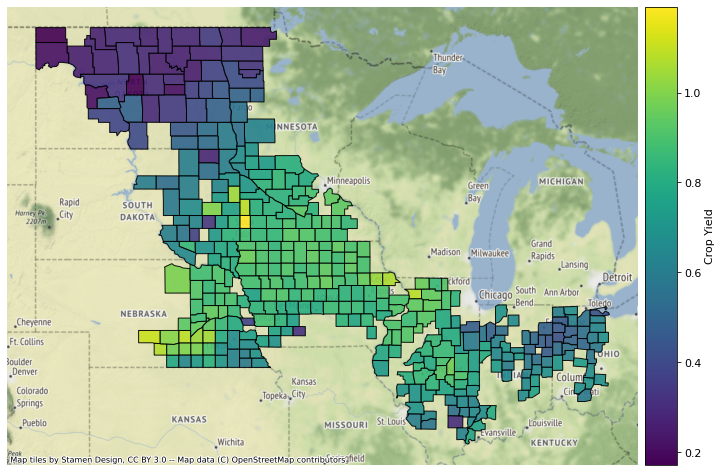

In [7]:
df_plot = df.to_crs(epsg=3857)
pars = {"size": 11}
plt.rc("font", **pars)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
df_plot.plot(column="yield", ax=ax,
            edgecolor='k', cmap="viridis", alpha=0.9,legend=True, cax=cax, legend_kwds={'label': 'Crop Yield'})
ax.set_aspect("equal")
# ax1.set_xlim([-1.04e7, -0.94e7])
ctx.add_basemap(ax)
ax.axis('off')
fig.savefig(f"../../results/dr_paper/data_dr.pdf", bbox_inches="tight")

In [8]:
def random_points_in_polygon(number, polygon):
    """Sample uniformly in a polygon
    
    """
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        long = random.uniform(min_x, max_x)
        lat = random.uniform(min_y, max_y)
        point = Point(long, lat)
        if polygon.contains(point):
            points.append([long, lat])
            i += 1
    return points # returns list of shapely point

In [9]:
print(polygon_geom.exterior.coords.xy)

(array('d', [-97.637496, -97.399191, -97.160544, -97.16054299999999, -97.16036, -97.1650703923738, -97.213957, -97.23786799999999, -97.302075, -97.34118099999999, -97.41706599999999, -97.45217699999999, -97.48491687634201, -97.515948, -97.59926, -97.6354420904415, -97.637496]), array('d', [43.168769999999995, 43.169419, 43.169978, 43.083144999999995, 42.811795, 42.7916166414677, 42.820142999999995, 42.853139, 42.86566, 42.855882, 42.865918, 42.846047999999996, 42.850003214867904, 42.853752, 42.856229, 42.85180907518549, 43.168769999999995]))


## Calculate the max number of items in a bag

In [10]:
max_VOD = 0
max_EVI = 0
for i in df.index.values:
    if type(data["data"]["EVI"][0][0][i][0]) == np.float64:
        EVI_length = 1
    else:
        EVI_length = data["data"]["EVI"][0][0][i][0][:-1].shape[0]
        
    if type(data["data"]["VOD"][0][0][i][0]) == np.float64:
        VOD_length = 1
    else:
        VOD_length = data["data"]["VOD"][0][0][i][0][:-1].shape[0]
    max_EVI = max(max_EVI, EVI_length)
    max_VOD = max(max_VOD, VOD_length)
#     print(EVI_length, VOD_length)
dim_VOD = 213
dim_EVI = 13

## Read out the dataset from the `.mat` file and put into a dictionary with keys being the bag

In [16]:
def create_spatial_data_dict(data, df, indices, max_VOD, max_EVI, space_length=100):
    """Put the dataset into a dictionary by:

    - Concatenating the EVI and VOD covariates
    - Add in another set of spatial covariates of length space_length
    - Setting weights to be $1/N_a$ - uniform weights

    Args:
        data ([type]): [description]
        df ([type]): [description]
        indices ([type]): [description]
        max_VOD ([type]): [description]
        max_EVI ([type]): [description]
        space_length ([type]): [description]
    """
    dict_data = {}

    for i in tqdm(indices):
        x_VOD = np.zeros((max_VOD, 213))
        x_EVI = np.zeros((max_EVI, 13))
        if type(data["data"]["EVI"][0][0][i][0]) == np.float64:
            x_EVI[:1] = data["data"]["EVI"][0][0][i][0, :13]
            EVI_length = 1
        else:
            EVI_length = int(data["data"]["EVI"][0][0][i][0][:-1].shape[0])
            x_EVI[:EVI_length] = data["data"]["EVI"][0][0][i][0][:-1, :13]
            
        if type(data["data"]["VOD"][0][0][i][0]) == np.float64:
            x_VOD[:1] = data["data"]["VOD"][0][0][i][0][:, :213]
            VOD_length = 1
        else:
            VOD_length = int(data["data"]["VOD"][0][0][i][0][:-1].shape[0])
            x_VOD[:VOD_length] = data["data"]["VOD"][0][0][i][0][:-1, :213]

        x_space = np.array(random_points_in_polygon(space_length, df.geometry[i]))
            
        weights_VOD = np.zeros((max_VOD, 1))
        weights_EVI = np.zeros((max_EVI, 1))
        weights_VOD[: VOD_length, 0] = 1/VOD_length
        weights_EVI[: EVI_length, 0] = 1/EVI_length
#         y = np.log(data["data"]["Y"][0][0][i][0])
        y = data["data"]["Y"][0][0][i][0]
#         print(VOD_length, EVI_length)

        dict_data[str(i)] = {
            "space_length": space_length,
            "VOD_length": VOD_length,
            "EVI_length": EVI_length,
            "weights_space": np.expand_dims(np.array([1 / space_length] * space_length), axis=1),
            "weights_VOD": weights_VOD,
            "weights_EVI": weights_EVI,
            "x_space": x_space,
            "x_VOD": x_VOD,
            "x_EVI": x_EVI,
            "y": np.expand_dims(y, 0),        
        }
    return dict_data

def create_data_dict(data, indices, max_VOD, max_EVI):
    """Put the dataset into a dictionary by:

    - Concatenating the EVI and VOD covariates
    - Setting weights to be $1/N_a$ - uniform weights
    - 

    Args:
        data ([type]): [description]
        indices ([type]): [description]
        max_VOD ([type]): [description]
        max_EVI ([type]): [description]
    """
    dict_data = {}

    for i in indices:
        x_VOD = np.zeros((max_VOD, 213))
        x_EVI = np.zeros((max_EVI, 13))
        if type(data["data"]["EVI"][0][0][i][0]) == np.float64:
            x_EVI[:1] = data["data"]["EVI"][0][0][i][0, :13]
            EVI_length = 1
        else:
            EVI_length = int(data["data"]["EVI"][0][0][i][0][:-1].shape[0])
            x_EVI[:EVI_length] = data["data"]["EVI"][0][0][i][0][:-1, :13]
            
        if type(data["data"]["VOD"][0][0][i][0]) == np.float64:
            x_VOD[:1] = data["data"]["VOD"][0][0][i][0][:, :213]
            VOD_length = 1
        else:
            VOD_length = int(data["data"]["VOD"][0][0][i][0][:-1].shape[0])
            x_VOD[:VOD_length] = data["data"]["VOD"][0][0][i][0][:-1, :213]
        
        weights_VOD = np.zeros((max_VOD, 1))
        weights_EVI = np.zeros((max_EVI, 1))
        weights_VOD[: VOD_length, 0] = 1/VOD_length
        weights_EVI[: EVI_length, 0] = 1/EVI_length
#         y = np.log(data["data"]["Y"][0][0][i][0])
        y = data["data"]["Y"][0][0][i][0]
#         print(VOD_length, EVI_length)

        dict_data[str(i)] = {
            "VOD_length": VOD_length,
            "EVI_length": EVI_length,
            "weights_VOD": weights_VOD,
            "weights_EVI": weights_EVI,
            "x_VOD": x_VOD,
            "x_EVI": x_EVI,
            "y": np.expand_dims(y, 0),        
        }
    return dict_data

## Shuffle the county index

In [17]:
indices = list(df.index.values)
random.seed(1)
shuffled_indices = random.sample(indices, 375)

In [18]:
geom = df.geometry[0]

## Linear Regression

Average the covariates over space and days

In [19]:
from sklearn.linear_model import LinearRegression

Partition k=0, RMSE:  0.38887777925531103
Time:  0.058966636657714844
Partition k=1, RMSE:  0.3172210388722683
Time:  0.05200791358947754
Partition k=2, RMSE:  0.20710077300235624
Time:  0.03286457061767578
Partition k=3, RMSE:  0.24259513710455313
Time:  0.05067324638366699
Partition k=4, RMSE:  0.4476924411796382
Time:  0.03392529487609863
CV-RMSE: 0.32069743388282534, CV-MAPE: 0.4106021481982044


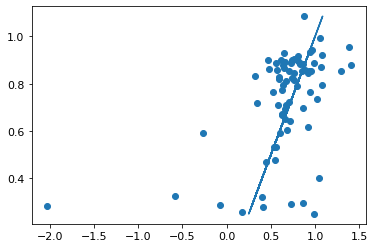

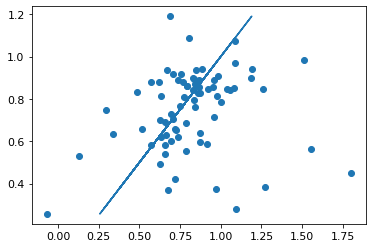

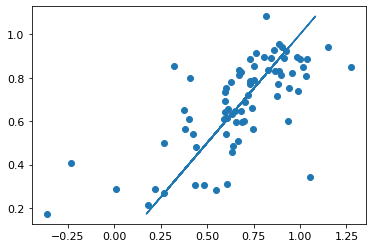

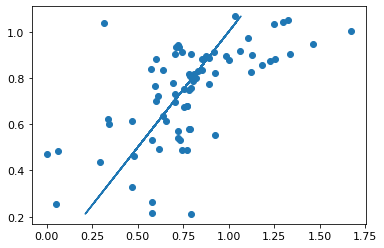

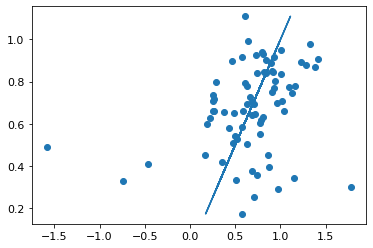

In [33]:
# linear regression
RMSE = []
MAPE  = []
training_time = []
for k in range(5):
    train_indices = shuffled_indices[:k*75] + shuffled_indices[(k+1)*75:]
    test_indices = shuffled_indices[k*75: (k+1)*75]
    train_set = create_data_dict(data, train_indices, max_VOD, max_EVI)
    test_set = create_data_dict(data, test_indices, max_VOD, max_EVI)
    
    # linear model
    # form dataset with centroids
    keys = list(train_set.keys())
    df_train = pd.DataFrame(columns=[f"VOD_{i}" for i in range(dim_VOD)] + [f"EVI_{i}" for i in range(dim_EVI)]+["y"])
    for i, key in enumerate(list(keys)):
        x = np.concatenate([np.mean(train_set[key]["x_VOD"], axis=0), np.mean(train_set[key]["x_EVI"], axis=0)])
        df_train.loc[i] = np.concatenate([x, train_set[key]["y"]])

    keys = list(test_set.keys())
    df_test = pd.DataFrame(columns=[f"VOD_{i}" for i in range(dim_VOD)] + [f"EVI_{i}" for i in range(dim_EVI)]+ ["y"])
    for i, key in enumerate(list(keys)):
        x = np.concatenate([np.mean(test_set[key]["x_VOD"], axis=0), np.mean(test_set[key]["x_EVI"], axis=0)])
        df_test.loc[i] = np.concatenate([x, test_set[key]["y"]])

    X = df_train.iloc[:,:-1].values
    y = df_train.iloc[:,-1].values
    t0 = time.time()
    reg = LinearRegression().fit(X, y)
    t1 = time.time()
    pred = reg.predict(df_train.iloc[:, :-1])

#     plt.figure()
#     plt.scatter(pred, df_train.iloc[:, -1])
#     plt.plot(df_train.iloc[:, -1], df_train.iloc[:, -1])
#     print(f"CV k={k}, RMSE: ", np.sqrt(np.mean((pred - df_train.iloc[:, -1])**2)))
    
    df_test.iloc[:, -1] = df_test.iloc[:, -1]
    pred = reg.predict(df_test.iloc[:, :-1])
    RMSE.append(np.sqrt(np.mean((pred - df_test.iloc[:, -1].values)**2)))
    MAPE.append(np.mean(np.abs(( pred - df_test.iloc[:, -1].values ) / df_test.iloc[:, -1].values)))
    training_time.append(t1-t0)
    plt.figure()
    plt.scatter(pred, df_test.iloc[:, -1])
    plt.plot(df_test.iloc[:, -1], df_test.iloc[:, -1])
    print(f"Partition k={k}, RMSE: ", np.sqrt(np.mean((pred - df_test.iloc[:, -1])**2)))
    print("Time: ", t1-t0)
print(f"CV-RMSE: {sum(RMSE) / 5}, CV-MAPE: {sum(MAPE) / 5}")

In [34]:
{"CV-RMSE": sum(RMSE) / 5, "CV-MAPE": sum(MAPE) / 5, 
                       "CV-sd-RMSE": sem(RMSE), "CV-sd-MAPE": sem(MAPE),
                        "Training Time": sum(training_time)/5, "Training Time sd": sem(training_time)}

{'CV-RMSE': 0.32069743388282534,
 'CV-MAPE': 0.4106021481982044,
 'CV-sd-RMSE': 0.04460523894170505,
 'CV-sd-MAPE': 0.05888866727287904,
 'Training Time': 0.045687532424926756,
 'Training Time sd': 0.005214967653946262}

In [35]:
import json
json_file = json.dumps({"CV-RMSE": sum(RMSE) / 5, "CV-MAPE": sum(MAPE) / 5, 
                       "CV-sd-RMSE": sem(RMSE), "CV-sd-MAPE": sem(MAPE),
                        "Training Time": sum(training_time)/5, "Training Time sd": sem(training_time)})
f = open('../../results/dr_paper/LR_CV.json', "w")
f.write(json_file)
f.close()

## S-KRR Experiments

In [36]:
from src.krr import LRe, KRRe
from src.bagData import BagData, BagDataGenerator
from typing import Callable
from sklearn.cluster import KMeans

class MultiResolutionBagData(BagData):
    """
    """

    def __init__(self, bag_data: dict) -> None:
        super().__init__(bag_data)
        
    def _create_subset(
        self, initial_num_items: int, initialisationMethod: Callable = None
    ) -> None:

        raise NotImplementedError()
    def __getitem__(self, bag):
        """
            bag: bag index from indexing system
        """
        return (
            self.bag_data[bag]["space_length"],
            self.bag_data[bag]["VOD_length"],
            self.bag_data[bag]["EVI_length"],
            self.bag_data[bag]["weights_space"],
            self.bag_data[bag]["weights_VOD"],
            self.bag_data[bag]["weights_EVI"],
            self.bag_data[bag]["x_space"],
            self.bag_data[bag]["x_VOD"],
            self.bag_data[bag]["x_EVI"],
            self.bag_data[bag]["y"],
        )

class MultiResolutionBagDataGenerator(MultiResolutionBagData):
    def __init__(self, bag_data: dict, num_inducing_us: int = 1, num_inducing_u1: int = 1, num_inducing_u2: int = 1) -> None:
        super().__init__(bag_data)
        self.num_inducing_us = num_inducing_us
        self.num_inducing_u1 = num_inducing_u1
        self.num_inducing_u2 = num_inducing_u2
        self.kmeans_s = KMeans(n_clusters=num_inducing_us)
        self.kmeans_1 = KMeans(n_clusters=num_inducing_u1)
        self.kmeans_2 = KMeans(n_clusters=num_inducing_u2)
        self.dim_space = 2
        self.dim_1 = self.__getitem__(self.bags[0])[-3].shape[1]
        self.dim_2 = self.__getitem__(self.bags[0])[-2].shape[1]

    def gen_bags(self):
        for bag in self.bags:
            yield self.__getitem__(bag)

    def gen_inducing(self) -> np.ndarray:
        landmark_points_us = np.zeros(
            [self.num_bags * self.num_inducing_us, self.dim_space]
        )
        landmark_points_u1 = np.zeros(
            [self.num_bags * self.num_inducing_u1, self.dim_1]
        )
        landmark_points_u2 = np.zeros(
            [self.num_bags * self.num_inducing_u1, self.dim_2]
        )
        for i, bag in enumerate(self.bags):
            landmark_points_us[
                i * self.num_inducing_us : i * self.num_inducing_us
                + self.num_inducing_us,
                :,
            ] = self.kmeans_s.fit(
                self.__getitem__(bag)[-3]
            ).cluster_centers_
            
            landmark_points_u1[
                i * self.num_inducing_u1 : i * self.num_inducing_u1
                + self.num_inducing_u1,
                :,
            ] = self.kmeans_1.fit(
                self.__getitem__(bag)[-3]
            ).cluster_centers_
            
            landmark_points_u2[
                i * self.num_inducing_u2 : i * self.num_inducing_u2
                + self.num_inducing_u2,
                :,
            ] = self.kmeans_2.fit(
                self.__getitem__(bag)[-2]
            ).cluster_centers_
        return landmark_points_us, landmark_points_u1, landmark_points_u2

In [37]:
class MultiResolutionLRe(LRe):
    def __init__(self, train_bag: BagData, kernel_space: gpflow.kernels.Kernel, kernel_1: gpflow.kernels.Kernel, kernel_2: gpflow.kernels.Kernel, lmbda: np.float = 0.1) -> None:
        super().__init__(train_bag, kernel_space, lmbda)
        self.kernel_1 = kernel_1
        self.kernel_2 = kernel_2
        
        
    def bag_cov(self, bag_data1: BagData, bag_data2: BagData = None) -> np.ndarray:
        bags1 = bag_data1.bags
        if bag_data2:
            bags2 = bag_data2.bags
        else:
            bag_data2 = bag_data1
            bags2 = bag_data1.bags

        K = np.zeros((len(bags1), len(bags2)))

        for i, bag1 in tqdm(enumerate(bags1)):
            for j, bag2 in enumerate(bags2):
                _, VOD_length_i, EVI_length_i, _, _, _, x_space_i, x_VOD_i, x_EVI_i, _ = bag_data1[bag1]
                _, VOD_length_j, EVI_length_j, _, _, _, x_space_j, x_VOD_j, x_EVI_j, _ = bag_data2[bag2]
                x_VOD_i, x_EVI_i = x_VOD_i[:VOD_length_i, :], x_EVI_i[:EVI_length_i, :]
                x_VOD_j, x_EVI_j = x_VOD_j[:VOD_length_j, :], x_EVI_j[:EVI_length_j, :]
                K[i, j] = np.mean(self.kernel(x_space_i, x_space_j)) + np.mean(self.kernel_1(x_VOD_i, x_VOD_j) + self.kernel_2(x_EVI_i, x_EVI_j))
        return K

class MultiResolutionKRRe(KRRe):
    def __init__(self, train_bag: BagData, kernel_space: gpflow.kernels.Kernel, kernel_1: gpflow.kernels.Kernel, kernel_2: gpflow.kernels.Kernel, lmbda: np.float = 0.1) -> None:
        super().__init__(train_bag, kernel_space, lmbda)
        self.kernel_1 = kernel_1
        self.kernel_2 = kernel_2
        
        
    def bag_cov(self, bag_data1: BagData, bag_data2: BagData = None, median_heuristic=False) -> np.ndarray:
        bags1 = bag_data1.bags
        if bag_data2:
            bags2 = bag_data2.bags
        else:
            bag_data2 = bag_data1
            bags2 = bag_data1.bags

        K = np.zeros((len(bags1), len(bags2)))

        for i, bag1 in tqdm(enumerate(bags1)):
            for j, bag2 in enumerate(bags2):
                _, VOD_length_i, EVI_length_i, _, _, _, x_space_i, x_VOD_i, x_EVI_i, _ = bag_data1[bag1]
                _, VOD_length_j, EVI_length_j, _, _, _, x_space_j, x_VOD_j, x_EVI_j, _ = bag_data2[bag2]
                x_VOD_i, x_EVI_i = x_VOD_i[:VOD_length_i, :], x_EVI_i[:EVI_length_i, :]
                x_VOD_j, x_EVI_j = x_VOD_j[:VOD_length_j, :], x_EVI_j[:EVI_length_j, :]
                K[i, j] = np.mean(self.kernel(x_space_i, x_space_i)) + np.mean(self.kernel_1(x_VOD_i, x_VOD_i) + self.kernel_2(x_EVI_i, x_EVI_i)) - 2*(np.mean(self.kernel(x_space_i, x_space_j)) + np.mean(self.kernel_1(x_VOD_i, x_VOD_j)+self.kernel_2(x_EVI_i, x_EVI_j))) + np.mean(self.kernel(x_space_j, x_space_j)) + np.mean(self.kernel_1(x_VOD_j, x_VOD_j)+self.kernel_2(x_EVI_j, x_EVI_j))

        if median_heuristic == True:
            self.lengthscale_rho = np.quantile(scipy.spatial.distance.pdist(np.expand_dims(K.flatten(), axis=1), metric="euclidean"), 0.5)
        return self.scale_rho * np.exp(-K / (2 * self.lengthscale_rho))


RMSE:  0.05803758422346357
586.9322192668915



RMSE:  0.07097694415808599
597.4517049789429



RMSE:  0.0821096998948412
600.185905456543



RMSE:  0.06807323670002334
602.878653049469



RMSE:  0.08402115785292441
600.6015276908875
CV-RMSE: 0.0726437245658677, CV-MAPE: 0.0798043040341874, Training Time: 597.6100020885467


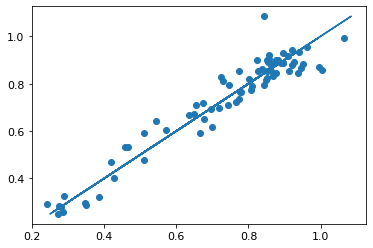

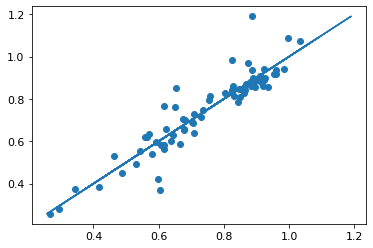

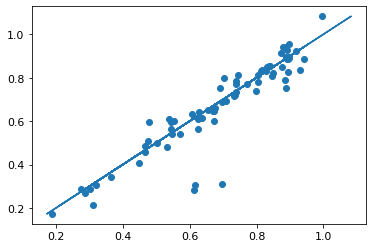

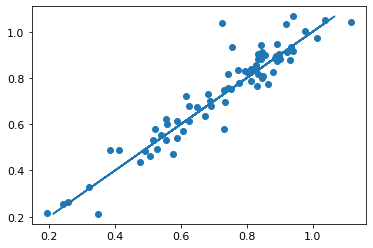

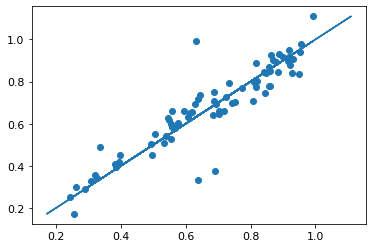

In [38]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# KRR
RMSE = []
MAPE = []
training_time = []
for k in range(5):
    train_indices = shuffled_indices[:k*75] + shuffled_indices[(k+1)*75:]
    test_indices = shuffled_indices[k*75: (k+1)*75]
    train_set = create_spatial_data_dict(data, df, train_indices, max_VOD, max_EVI)
    test_set = create_spatial_data_dict(data, df, test_indices, max_VOD, max_EVI)

    # form dataset with centroids
    keys = list(train_set.keys())
    train_bag = MultiResolutionBagDataGenerator(train_set)
    train_bag.y = train_bag.y
    
    s = np.zeros((0, 2))
    x1 = np.zeros((0, train_bag.dim_1))
    x2 = np.zeros((0, train_bag.dim_2))
    for i, bag in enumerate(train_bag.bags):
        s = np.vstack([s, train_bag[bag][-4][:10]])
        
        if train_bag[bag][1] < 10:
            num_VOD = train_bag[bag][1]
        else:
            num_VOD = 10
        x1 = np.vstack([x1, train_bag[bag][-3][:num_VOD]])
        x2 = np.vstack([x2, train_bag[bag][-2][:num_VOD]])
    s_distances = scipy.spatial.distance.pdist(s, metric='euclidean')
    x1_distances = scipy.spatial.distance.pdist(x1, metric='euclidean')
    x2_distances = scipy.spatial.distance.pdist(x2, metric='euclidean')
    s_median = np.quantile(s_distances, 0.5)
    x1_median = np.quantile(x1_distances, 0.5)
    x2_median = np.quantile(x2_distances, 0.5)
    
    ks = gpflow.kernels.Matern32(lengthscales=s_median)
    k1 = gpflow.kernels.SquaredExponential(lengthscales=x1_median)
    k2 = gpflow.kernels.SquaredExponential(lengthscales=x2_median)
    
#     k1 = gpflow.kernels.Linear()
#     k2 = gpflow.kernels.Linear()
    krr = MultiResolutionLRe(train_bag, ks, k1, k2)
    t0 = time.time()
    krr.fit()
    t1 = time.time()
    test_bag = MultiResolutionBagDataGenerator(test_set)
    test_bag.y = test_bag.y
    fstar_krr = krr.predict(test_bag)
    plt.figure()
    plt.scatter(fstar_krr, test_bag.y)
    plt.plot(test_bag.y, test_bag.y) 
    print("RMSE: ", np.sqrt(np.mean((fstar_krr - test_bag.y)**2)))
    MAPE.append(np.mean(np.abs(( fstar_krr - test_bag.y ) / test_bag.y)))
    RMSE.append(np.sqrt(np.mean((fstar_krr - test_bag.y)**2)))
    training_time.append(t1-t0)
    print(t1-t0)
print(f"CV-RMSE: {sum(RMSE) / 5}, CV-MAPE: {sum(MAPE) / 5}, Training Time: {sum(training_time)/5}")

In [39]:
training_time

[586.9322192668915,
 597.4517049789429,
 600.185905456543,
 602.878653049469,
 600.6015276908875]

In [40]:
{"CV-RMSE": sum(RMSE) / 5, "CV-MAPE": sum(MAPE) / 5, 
                       "CV-sd-RMSE": sem(RMSE), "CV-sd-MAPE": sem(MAPE),
                        "Training Time": sum(training_time)/5, "Training Time se": sem(training_time)}


{'CV-RMSE': 0.0726437245658677,
 'CV-MAPE': 0.0798043040341874,
 'CV-sd-RMSE': 0.004775235748587507,
 'CV-sd-MAPE': 0.006948753102049119,
 'Training Time': 597.6100020885467,
 'Training Time se': 2.805203116532619}

In [41]:
json_file = json.dumps({"CV-RMSE": sum(RMSE) / 5, "CV-MAPE": sum(MAPE) / 5, 
                       "CV-sd-RMSE": sem(RMSE), "CV-sd-MAPE": sem(MAPE),
                        "Training Time": sum(training_time)/5, "Training Time se": sem(training_time)}
)
f = open('../../results/dr_paper/LRe_spatial_CV.json', "w")
f.write(json_file)
f.close()

## KRRe


RMSE:  0.05432478891296651
1809.5190813541412



RMSE:  0.07162149866906029
1732.5806212425232



RMSE:  0.0830473006798585
1728.4718706607819



RMSE:  0.06900473593339271
1747.463259935379



RMSE:  0.08514610423613862
1739.4191601276398
CV-RMSE: 0.07262888568628333, CV-MAPE: 0.08060153228819178, Training Time: 1751.490798664093


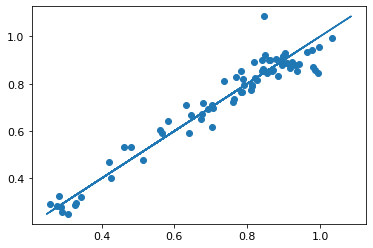

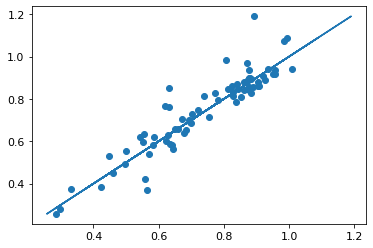

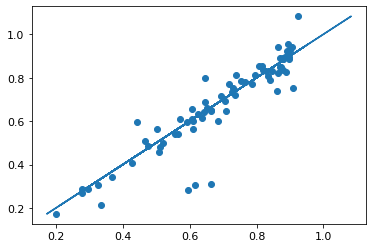

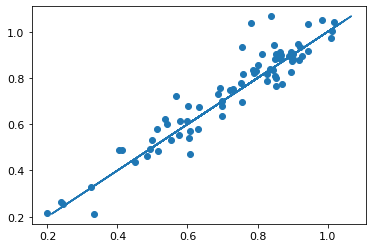

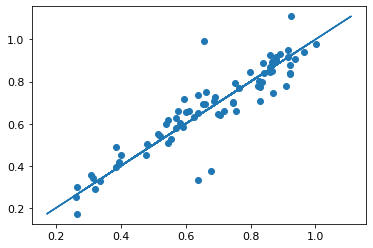

In [42]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# KRR
RMSE = []
MAPE = []
training_time = []
for k in range(5):
    train_indices = shuffled_indices[:k*75] + shuffled_indices[(k+1)*75:]
    # train_indices = shuffled_indices[:10]
    test_indices = shuffled_indices[k*75: (k+1)*75]
    train_set = create_spatial_data_dict(data, df, train_indices, max_VOD, max_EVI)
    test_set = create_spatial_data_dict(data, df, test_indices, max_VOD, max_EVI)

    # form dataset with centroids
    keys = list(train_set.keys())
    train_bag = MultiResolutionBagDataGenerator(train_set)
    train_bag.y = train_bag.y
    
    s = np.zeros((0, 2))
    x1 = np.zeros((0, train_bag.dim_1))
    x2 = np.zeros((0, train_bag.dim_2))
    for i, bag in enumerate(train_bag.bags):
        s = np.vstack([s, train_bag[bag][-4][:10]])
        
        if train_bag[bag][1] < 10:
            num_VOD = train_bag[bag][1]
        else:
            num_VOD = 10
        x1 = np.vstack([x1, train_bag[bag][-3][:num_VOD]])
        x2 = np.vstack([x2, train_bag[bag][-2][:num_VOD]])
    s_distances = scipy.spatial.distance.pdist(s, metric='euclidean')
    x1_distances = scipy.spatial.distance.pdist(x1, metric='euclidean')
    x2_distances = scipy.spatial.distance.pdist(x2, metric='euclidean')
    s_median = np.quantile(s_distances, 0.5)
    x1_median = np.quantile(x1_distances, 0.5)
    x2_median = np.quantile(x2_distances, 0.5)
    
    ks = gpflow.kernels.Matern32(lengthscales=s_median)
    k1 = gpflow.kernels.SquaredExponential(lengthscales=x1_median)
    k2 = gpflow.kernels.SquaredExponential(lengthscales=x2_median)
    
#     k1 = gpflow.kernels.Linear()
#     k2 = gpflow.kernels.Linear()
    krr = MultiResolutionKRRe(train_bag, ks, k1, k2)
    t0 = time.time()
    krr.fit(median_heuristic=True)
    t1 = time.time()
    test_bag = MultiResolutionBagDataGenerator(test_set)
    test_bag.y = test_bag.y
    fstar_krr = krr.predict(test_bag)
    plt.figure()
    plt.scatter(fstar_krr, test_bag.y)
    plt.plot(test_bag.y, test_bag.y) 
    print("RMSE: ", np.sqrt(np.mean((fstar_krr - test_bag.y)**2)))
    MAPE.append(np.mean(np.abs(( fstar_krr - test_bag.y ) / test_bag.y)))
    RMSE.append(np.sqrt(np.mean((fstar_krr - test_bag.y)**2)))
    training_time.append(t1-t0)
    print(t1-t0)
print(f"CV-RMSE: {sum(RMSE) / 5}, CV-MAPE: {sum(MAPE) / 5}, Training Time: {sum(training_time)/5}")

In [43]:
{"CV-RMSE": sum(RMSE) / 5, "CV-MAPE": sum(MAPE) / 5, 
                       "CV-sd-RMSE": sem(RMSE), "CV-sd-MAPE": sem(MAPE),
                        "Training Time": sum(training_time)/5, "Training Time sd": sem(training_time)}


{'CV-RMSE': 0.07262888568628333,
 'CV-MAPE': 0.08060153228819178,
 'CV-sd-RMSE': 0.0055426229346943095,
 'CV-sd-MAPE': 0.008263125221645665,
 'Training Time': 1751.490798664093,
 'Training Time sd': 14.86050634005971}

In [44]:
json_file = json.dumps({"CV-RMSE": sum(RMSE) / 5, "CV-MAPE": sum(MAPE) / 5, 
                       "CV-sd-RMSE": sem(RMSE), "CV-sd-MAPE": sem(MAPE),
                        "Training Time": sum(training_time)/5, "Training Time sd": sem(training_time)})
f = open('../../results/dr_paper/KRRe_spatial_CV.json', "w")
f.write(json_file)
f.close()